# Code Business Analytics Assignment 3 - group ...

--------------------------------------------------

# Importing Data

In [10]:
import pandas as pd
import json
import numpy as np

In [13]:
#Importing the data from .txt file
data = pd.read_csv('DataTrain.txt', sep=" ", header=None)
data.columns = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'NA', 'NA']
del data['NA']

# Creating and adding the RUL to the dataframe
RUL_list = []
for engine in set(data['engine_id']):
    max_cycle = data.loc[data['engine_id'] == engine].cycle.max()
    
    for cycle in list(data.loc[data['engine_id'] == engine].cycle):
        RUL_list.append(max_cycle - cycle +1)    
        
# data['RUL'] = RUL_list

data.insert(2, 'RUL', RUL_list)

data.head()
dcolumns = data.columns
dcolumns.to_json ('Table.json', orient='records')

engine_id  cycle  RUL  setting1  setting2  setting3      s1      s2  \
0          1      1  192   -0.0007   -0.0004     100.0  518.67  641.82   
1          1      2  191    0.0019   -0.0003     100.0  518.67  642.15   
2          1      3  190   -0.0043    0.0003     100.0  518.67  642.35   
3          1      4  189    0.0007    0.0000     100.0  518.67  642.35   
4          1      5  188   -0.0019   -0.0002     100.0  518.67  642.37   

        s3       s4  ...     s12      s13      s14     s15   s16  s17   s18  \
0  1589.70  1400.60  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388   
1  1591.82  1403.14  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388   
2  1587.99  1404.20  ...  522.42  2388.03  8133.23  8.4178  0.03  390  2388   
3  1582.79  1401.87  ...  522.86  2388.08  8133.83  8.3682  0.03  392  2388   
4  1582.85  1406.22  ...  522.19  2388.04  8133.80  8.4294  0.03  393  2388   

     s19    s20      s21  
0  100.0  39.06  23.4190  
1  100.0  39.00  23.4236  
2  100.0  38.95  23.3442  
3  100.0  38.88  23.3739  
4  100.0  38.90  23.4044  

[5 rows x 27 columns]

# Prediction Task

## Check correlations within data

In [3]:
def create_correlation_matrix(data):
    correlation_matrix = data.corr(method = 'pearson')
    correlation_matrix = correlation_matrix.replace(1, 0)
    best_corr = correlation_matrix.max()
    print('Best overall corralation: ', best_corr)
    best_corr_RUL = correlation_matrix['RUL'].max()
    print('Best RUL correlation:', best_corr_RUL)
    return correlation_matrix

In [99]:
#Calculating correlations
print(create_correlation_matrix(data))

Best overall corralation:  engine_id    7.875253e-02
cycle        6.343845e-01
RUL          6.719831e-01
setting1     1.166044e-02
setting2     1.815635e-02
setting3              NaN
s1           6.935511e-09
s2           7.400200e-01
s3           6.959002e-01
s4           8.301357e-01
s5           6.935500e-09
s6           1.600145e-01
s7           8.127126e-01
s8           8.260843e-01
s9           9.631566e-01
s10          6.935505e-09
s11          8.301357e-01
s12          8.127126e-01
s13          8.260843e-01
s14          9.631566e-01
s15          7.809128e-01
s16          6.935514e-09
s17          7.222963e-01
s18                   NaN
s19                   NaN
s20          7.519431e-01
s21          7.562626e-01
dtype: float64
Best RUL correlation: 0.6719831036132967
              engine_id         cycle           RUL      setting1  \
engine_id  0.000000e+00  7.875253e-02  7.875253e-02 -1.789509e-02   
cycle      7.875253e-02  0.000000e+00 -7.362406e-01 -4.526813e-03   
RUL     

## Creating Features 

In [4]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [5]:
def features_per_engine(nclusters, clustering = True, MinMax = True, Delta = True, elbow = True):
    if clustering:
        X = data[['setting1', 'setting2', 'setting3']]

        #plots the elbow plot to determine right amount of clusters
        if elbow:
            wcss = []
            for i in range(1, 11):
                kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
                kmeans.fit(X)
                wcss.append(kmeans.inertia_)
            plt.plot(range(1, 11), wcss)
            plt.title('Elbow Method')
            plt.xlabel('Number of clusters')
            plt.ylabel('WCSS')
            plt.show()

        #creates the clusters
        kmeans = KMeans(n_clusters=nclusters).fit(X)
        data['settings_clusters'] = kmeans.predict(X)
    
    if clustering:
        features = data.columns[3:-1]
    else:
        features = data.columns[3:]
            
    for feature in features:
        if MinMax:
            #adding min and max for every feature per engine_id       
            data['max_' + feature] = data.groupby('engine_id')[feature].cummax()
            data['min_' + feature] = data.groupby('engine_id')[feature].cummin()

        if Delta:
            #creating delta for every feature per engine_id
            data['delta_' + feature] = data.groupby('engine_id')[feature].diff()
            data['delta_' + feature].fillna(0, inplace=True)
    
    return kmeans

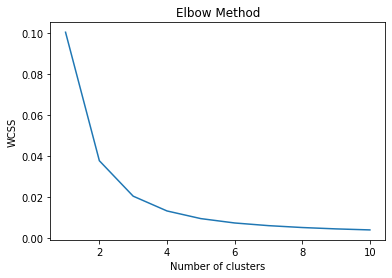

In [6]:
clusterkmeans = features_per_engine(3)

In [7]:
print(*data.columns, sep=', ')

engine_id, cycle, RUL, setting1, setting2, setting3, s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11, s12, s13, s14, s15, s16, s17, s18, s19, s20, s21, settings_clusters, max_setting1, min_setting1, delta_setting1, max_setting2, min_setting2, delta_setting2, max_setting3, min_setting3, delta_setting3, max_s1, min_s1, delta_s1, max_s2, min_s2, delta_s2, max_s3, min_s3, delta_s3, max_s4, min_s4, delta_s4, max_s5, min_s5, delta_s5, max_s6, min_s6, delta_s6, max_s7, min_s7, delta_s7, max_s8, min_s8, delta_s8, max_s9, min_s9, delta_s9, max_s10, min_s10, delta_s10, max_s11, min_s11, delta_s11, max_s12, min_s12, delta_s12, max_s13, min_s13, delta_s13, max_s14, min_s14, delta_s14, max_s15, min_s15, delta_s15, max_s16, min_s16, delta_s16, max_s17, min_s17, delta_s17, max_s18, min_s18, delta_s18, max_s19, min_s19, delta_s19, max_s20, min_s20, delta_s20, max_s21, min_s21, delta_s21


## Train Test Split

In [8]:
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn import metrics

In [9]:
# Making train test split
labels = data['RUL']
features = data.iloc[:,3:]
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size = 0.3, random_state = 42)

In [10]:
def train_test_split_custom(data, labels, features, test_split):
    seed(1)
    X_train = data.iloc[0:0]
    X_val = data.iloc[0:0]
    y_train = data.iloc[0:0]
    y_val = data.iloc[0:0]
    train_list = data.iloc[0:0]
    test_list = data.iloc[0:0]
    sequence = [i for i in range(1, 101, 1)]
    test = sample(sequence, test_split)
    train = [x for x in sequence if x not in test]
    for index, row in data.iterrows():
        if row['engine_id'] in train:
            train_list = train_list.append(row)
    for index, row in data.iterrows():
        if row['engine_id'] in test:
            test_list = test_list.append(row)
    X_train = train_list.iloc[:,3:]
    X_val = test_list.iloc[:,3:]
    y_train = train_list['RUL']
    y_val = test_list['RUL']

    return X_train, X_val, y_train, y_val

In [ ]:
#When this code is ran, the train-test split is made with only complete engine cycles
# labels = data['RUL']
# features = data.iloc[:,3:]
#X_train, X_val, y_train, y_val = train_test_split_custom(data, labels, features, test_split = 30)

## PCA

<font color='red'> The PCA was not used in the best performing model, so do not run this code! </font>

In [109]:
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 

In [94]:
def pca_features(X_train, X_val):
    X_scaler = StandardScaler()
    X_scaler.fit(X_train)
    X_train_img = X_scaler.transform(X_train)
    X_val_img = X_scaler.transform(X_val)
    pca = PCA(.95)
    pca.fit(X_train_img)
    X_train = pca.transform(X_train_img)
    X_val = pca.transform(X_val_img)
    return X_train, X_val

In [95]:
# X_train, X_val = pca_features(X_train, X_val)

## Parameter Tuning

In [28]:
#Functions for training four different machine learning models
def random_forest_reg(X_train, y_train, X_val, y_val):
    params = {'n_estimators': 100, 'max_depth':10}
    
    rf = ensemble.RandomForestRegressor(**params)
    rf.fit(X_train, y_train)
    
    print_evaluation_metrics(rf, "Random forest", X_val, y_val.values.ravel())
    print_evaluation_metrics2(rf, "Random forest", X_train, y_train.values.ravel())
    
    return rf

def gradient_boosting_reg(X_train, y_train, X_val, y_val):
    params = {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.25}
    
    clf = ensemble.GradientBoostingRegressor(**params)
    clf.fit(X_train, y_train)
    
    print_evaluation_metrics(clf, "Gradient Boosting Regressor", X_val, y_val.values.ravel())
    print_evaluation_metrics2(clf, "Gradient Boosting Regressor", X_train, y_train.values.ravel())
    
    return clf
 
def svm(X_train, y_train, X_val, y_val):
    params = {'gamma':'scale', 'kernel':'rbf'}
    
    model = SVR(**params) 
    model.fit(X_train, y_train)
    
    print_evaluation_metrics(model, "SVM", X_val, y_val.values.ravel())
    print_evaluation_metrics2(model, "SVM", X_train, y_train.values.ravel())
    
    return model
    

def adaBoost(X_train, y_train, X_val, y_val):
    params = {'random_state':24, 'n_estimators':100}
    
    regr = ensemble.AdaBoostRegressor(**params)
    regr.fit(X_train, y_train)
    
    print_evaluation_metrics(regr, "Ada Boost", X_val, y_val.values.ravel())
    print_evaluation_metrics2(regr, "Ada Boost", X_train, y_train.values.ravel())
    
    return regr

In [12]:
#These functions are used for printing and evaluating performance

def print_evaluation_metrics(trained_model, trained_model_name, X_test, y_test):
    print('--------- For Model: ', trained_model_name, ' ---------\n')
    predicted_values = trained_model.predict(X_test)
    print("Mean absolute error: ",
          metrics.mean_absolute_error(y_test, predicted_values))
    print("Median absolute error: ",
          metrics.median_absolute_error(y_test, predicted_values))
    print("Mean squared error: ", metrics.mean_squared_error(
        y_test, predicted_values))
    print("R2: ", metrics.r2_score(y_test, predicted_values))
    print("---------------------------------------")


def print_evaluation_metrics2(trained_model, trained_model_name, X_test, y_test):
    print('--------- For Model: ', trained_model_name, ' --------- (Train Data)\n')
    predicted_values = trained_model.predict(X_test)
    print("Mean absolute error: ",
          metrics.mean_absolute_error(y_test, predicted_values))
    print("Median absolute error: ",
          metrics.median_absolute_error(y_test, predicted_values))
    print("Mean squared error: ", metrics.mean_squared_error(
        y_test, predicted_values))
    print("R2: ", metrics.r2_score(y_test, predicted_values))
    print("---------------------------------------")

In [13]:
from matplotlib.legend_handler import HandlerLine2D
from sklearn.metrics import roc_curve, auc

In [33]:
#Function to perform parameter tuning for the two best algorithms : Gradient Boosting Regressor and Random Forest
def parameter_tuning(X_train, y_train, X_val, y_val, algorithm = 'gbr', lr = True, N_est = True, depth = True):
    if algorithm == 'gbr':
        if lr:
            #learning rate
            learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
            train_results = []
            test_results = []
            for eta in learning_rates:
                model = ensemble.GradientBoostingRegressor(learning_rate=eta)
                model.fit(X_train, y_train)
                train_pred = model.predict(X_train)
                MAE = metrics.mean_squared_error(y_train, train_pred)
                train_results.append(MAE)

                y_pred = model.predict(X_val)
                MAE = metrics.mean_squared_error(y_val, y_pred)
                test_results.append(MAE)

            line1, = plt.plot(learning_rates, train_results, 'b', label='Train MSE')
            line2, = plt.plot(learning_rates, test_results, 'r', label='Test MSE')
            plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
            plt.ylabel('MSE')
            plt.xlabel('learning rate')
            plt.title('GBR learning_rate tuning')
            plt.show()
        
        if N_est:
            #N_estimators
            n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200, 400, 600, 800]
            train_results = []
            test_results = []
            for eta in n_estimators:
                model = ensemble.GradientBoostingRegressor(n_estimators=eta)
                model.fit(X_train, y_train)
                train_pred = model.predict(X_train)
                MAE = metrics.mean_squared_error(y_train, train_pred)
                train_results.append(MAE)

                y_pred = model.predict(X_val)
                MAE = metrics.mean_squared_error(y_val, y_pred)
                test_results.append(MAE)

            line1, = plt.plot(n_estimators, train_results, 'b', label='Train MSE')
            line2, = plt.plot(n_estimators, test_results, 'r', label='Test MSE')
            plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
            plt.ylabel('MSE')
            plt.xlabel('n_estimators')
            plt.title('GBR n_estimators tuning')
            plt.show()
        
        if depth:
            #max_depth
            max_depths = np.linspace(1, 10, 10, endpoint=True)
            train_results = []
            test_results = []
            for eta in max_depths:
                model = ensemble.GradientBoostingRegressor(max_depth=eta)
                model.fit(X_train, y_train)
                train_pred = model.predict(X_train)
                MAE = metrics.mean_squared_error(y_train, train_pred)
                train_results.append(MAE)

                y_pred = model.predict(X_val)
                MAE = metrics.mean_squared_error(y_val, y_pred)
                test_results.append(MAE)

            line1, = plt.plot(max_depths, train_results, 'b', label='Train MSE')
            line2, = plt.plot(max_depths, test_results, 'r', label='Test MSE')
            plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
            plt.ylabel('MSE')
            plt.xlabel('max_depth')
            plt.title('GBR max_depth tuning')
            plt.show()
    
    if algorithm == 'rf':
        if N_est:
            #N_estimators
            n_estimators = [1, 2, 4, 8, 16, 32, 64, 128]
            train_results = []
            test_results = []
            for eta in n_estimators:
                model = ensemble.RandomForestRegressor(n_estimators=eta)
                model.fit(X_train, y_train)
                train_pred = model.predict(X_train)
                MAE = metrics.mean_absolute_error(y_train, train_pred)
                train_results.append(MAE)

                y_pred = model.predict(X_val)
                MAE = metrics.mean_absolute_error(y_val, y_pred)
                test_results.append(MAE)

            line1, = plt.plot(n_estimators, train_results, 'b', label='Train MAE')
            line2, = plt.plot(n_estimators, test_results, 'r', label='Test MAE')
            plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
            plt.ylabel('MAE')
            plt.xlabel('n_estimators')
            plt.title('RF n_estimators tuning')
            plt.show()
        
        if depth:
            #max_depth
            max_depths = np.linspace(1, 15, 15, endpoint=True)
            train_results = []
            test_results = []
            for eta in max_depths:
                model = ensemble.RandomForestRegressor(max_depth=eta)
                model.fit(X_train, y_train)
                train_pred = model.predict(X_train)
                MAE = metrics.mean_absolute_error(y_train, train_pred)
                train_results.append(MAE)

                y_pred = model.predict(X_val)
                MAE = metrics.mean_absolute_error(y_val, y_pred)
                test_results.append(MAE)

            line1, = plt.plot(max_depths, train_results, 'b', label='Train MAE')
            line2, = plt.plot(max_depths, test_results, 'r', label='Test MAE')
            plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
            plt.ylabel('MAE')
            plt.xlabel('max_depth')
            plt.title('RF max_depth tuning')
            plt.show()

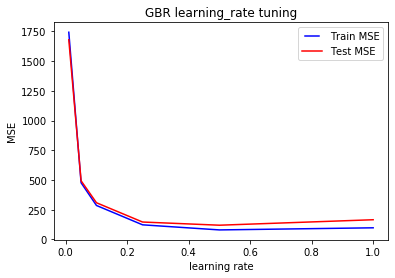

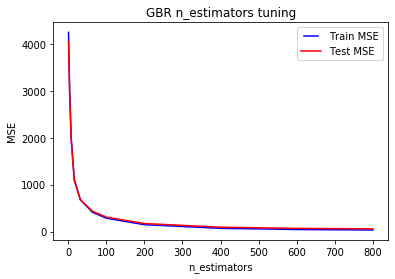

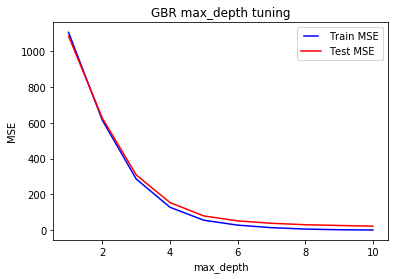

In [34]:
parameter_tuning(X_train, y_train, X_val, y_val)

## Training model

In [29]:
#Running models
print("------ Running random forest regressor ------")
random_forest_reg(X_train, y_train, X_val, y_val)

------ Running random forest regressor ------
--------- For Model:  Random forest  ---------

Mean absolute error:  5.5276867231990385
Median absolute error:  3.682578434753637
Mean squared error:  72.92306090010798
R2:  0.9840792370595227
---------------------------------------
--------- For Model:  Random forest  --------- (Train Data)

Mean absolute error:  4.743058713827503
Median absolute error:  3.0267350718853265
Mean squared error:  53.495840702031614
R2:  0.9888874506747073
---------------------------------------


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [16]:
print("--- Running Gradient Boosting Regressor ---")
gbr = gradient_boosting_reg(X_train, y_train, X_val, y_val)

--- Running Gradient Boosting Regressor ---
--------- For Model:  Gradient Boosting Regressor  ---------

Mean absolute error:  4.442303813863159
Median absolute error:  3.161749110373364
Mean squared error:  43.403927579855555
R2:  0.990523935320939
---------------------------------------
--------- For Model:  Gradient Boosting Regressor  --------- (Train Data)

Mean absolute error:  1.621833879184174
Median absolute error:  1.2981780044873261
Mean squared error:  4.450438648250651
R2:  0.9990755221649223
---------------------------------------


In [17]:
print("---------------- Running SVR ----------------")
svm(X_train, y_train, X_val, y_val)

---------------- Running SVR ----------------
--------- For Model:  SVM  ---------

Mean absolute error:  55.85141894065355
Median absolute error:  50.88194576799877
Mean squared error:  4637.509216532815
R2:  -0.01247374917292321
---------------------------------------
--------- For Model:  SVM  --------- (Train Data)

Mean absolute error:  57.09853314659068
Median absolute error:  52.86244002233168
Mean squared error:  4850.411145486816
R2:  -0.00756306275086871
---------------------------------------


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [18]:
print("--- Running ADABoost Regressor ---")
adaBoost(X_train, y_train, X_val, y_val)

--- Running ADABoost Regressor ---
--------- For Model:  Ada Boost  ---------

Mean absolute error:  29.09569560515158
Median absolute error:  29.44341859505841
Mean squared error:  1119.5932531065869
R2:  0.7555673259946578
---------------------------------------
--------- For Model:  Ada Boost  --------- (Train Data)

Mean absolute error:  29.029205057935062
Median absolute error:  29.862935928629355
Mean squared error:  1115.564050847274
R2:  0.7682668338719493
---------------------------------------


AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=100, random_state=24)

## Predicting RUL

In [28]:
# Code to convert python notebook to regular python file.
# !jupyter nbconvert --to python Assignment_3.ipynb

In [16]:
dataSchedule = pd.read_csv('DataSchedule.txt', sep=" ", header=None)
dataSchedule.columns = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'NA', 'NA']
del dataSchedule['NA']


dataSchedule.to_json ('predict_data.json', orient='records')
# dataSchedule.loc[dataSchedule['engine_id'] == 1]

In [20]:
def features_prediction(kmeans, MinMax = True, Delta = True):
    #Clustering
    X = dataSchedule[['setting1', 'setting2', 'setting3']]    
    dataSchedule['settings_clusters'] = kmeans.predict(X)
    
    #Creating min max and delta
    features = dataSchedule.columns[2:-1]
    for feature in features:
        if MinMax:
            #adding min and max for every feature per engine_id
            dataSchedule['max_' + feature] = data.groupby('engine_id')[feature].cummax()
            dataSchedule['min_' + feature] = data.groupby('engine_id')[feature].cummin()
    
        if Delta: 
            #creating delta for every feature per engine_id
            dataSchedule['delta_' + feature] = dataSchedule.groupby('engine_id')[feature].diff()
            dataSchedule['delta_' + feature].fillna(0, inplace=True)    
    

In [21]:
#creates the additional features likewise to the train data. Also using the trained Kmeans clustering algorithm
features_prediction(clusterkmeans)

In [22]:
#predicts the RUL values
x_prediction = dataSchedule.iloc[:,2:]
RUL_prediction = gbr.predict(x_prediction).round().astype(int)

#Getting data in usable format
dataSchedule.insert(2, "RUL", RUL_prediction)
RUL_list = dataSchedule.groupby('engine_id').RUL.last()
# RUL_list.to_excel('RUL_list.xlsx')

----------------------

# Optimization Task 1

## Data collection

In [ ]:
from pulp import *

In [ ]:
data_RUL.loc[data_RUL['RUL'] < 25]

In [28]:
data_RUL = RUL_list.to_frame()
data_RUL_consultancy = pd.read_csv('Data/RUL_consultancy_predictions_A3.csv', sep=';')
# data_RUL2 = pd.read_excel('RUL_list.xlsx')

In [ ]:
penalty_cost = [5]*20+[7]*20+[9]*20+[5]*20+[3]*20
mu_a = [4]*25+[6]*25+[3]*25+[5]*25
mu_b = [5]*25+[7]*8+[8]*17+[5]*17+[4]*8+[6]*25

Ga = [1,2]
Gb = [3,4]
G = Ga + Gb

# data_RUL['RUL'] = [0 if value < 0 else value for value in data_RUL['RUL'] ]
engines = list(set(data_RUL['engine_id']))

R_Consultancy = list(data_RUL_consultancy['RUL'])
R_Prediction = list(data_RUL['RUL'])

dict_mu_a = {index+1 : value for index, value in enumerate(mu_a)}
dict_mu_b = {index+1 : value for index, value in enumerate(mu_b)}

penalty_cost = {index+1 : value for index, value in enumerate(penalty_cost)}

mu_dict = {}
for i in G:
    if i in Ga:
        mu_dict[i] = dict_mu_a
    else:
        mu_dict[i] = dict_mu_b

## Part A: Total Model

In [ ]:
def model(planning_horizon, R):
    D = LpVariable.dicts('Team_i_STARTS_to_work_on_engine_j_day_t', 
                    [(i,j,t) for j in engines for i in G for t in range(1, planning_horizon + 1)]
                    , lowBound = 0, upBound = 1, cat='Integer')

    X = LpVariable.dicts('Opposite of D', 
                    [(i,j,t) for j in engines for i in G for t in range(1, planning_horizon + 1)]
                    , lowBound = 0, upBound = 1, cat='Integer')
    
    model = LpProblem('RUL_prediction', LpMinimize)
    
    # objective function
    model += lpSum(penalty_cost[j]*D[(i,j,t)]*max(((t+mu_dict[i][j] -1) -R[j-1]), 0) for j in engines for i in G for t in range(1, planning_horizon+1)) + lpSum(max(0,planning_horizon-R[j-1])*penalty_cost[j]*(lpSum(X[(i,j,t)] for i in G for t in range(1, planning_horizon+1)) - (len(G) * planning_horizon - 1)) for j in engines) 
    
    #constraints
    for i in G:
        for day in range(1, planning_horizon + 1):
            for j in engines:
                model += lpSum(D[(i,j,t)] for t in range(day, min(day + mu_dict[i][j] - 1, planning_horizon) + 1) for j in engines ) <= 1

    for j in engines:
        model += lpSum(D[(i,j,t)] for t in range(1, planning_horizon+1) for i in G) <= 1

    for i in G:
        model += lpSum(D[(i,j,t)] for t in range(max(planning_horizon-mu_dict[i][j] + 2, 0), planning_horizon+1) for j in engines) == 0

    for j in engines:
        for i in G:
            for t in range(1, planning_horizon + 1):
                model += D[(i,j,t)] + X[(i,j,t)] == 1
                
    model.solve()
    print('Status:', LpStatus[model.status])
    teama = ['Schedule of teams of type a:']
    teamb = ['Schedule of teams of type b:']
    costs = ['Penalty costs of engines which are repaired:']
    for j in engines:
        for i in G:
            for t in range(1, planning_horizon + 1):
                if D[(i,j,t)].varValue > 0:
                    costs_per_engine = penalty_cost[j]*D[(i,j,t)].varValue*max(((t+mu_dict[i][j] -1) -R[j-1]), 0)
                    if costs_per_engine > 0:
                        costs.append('The penalty costs of engine {} are {}'.format(j,costs_per_engine))
                if D[(i,j,t)].varValue > 0:
                    if i in Ga:
                        teama.append('Team {} starts working on engine {} on t = {} until t = {}'.format(i,j,t, t+mu_a[j-1]-1))
                    if i in Gb:
                        teamb.append('Team {} starts working on engine {} on t = {} until t = {}'.format(i,j,t, t+mu_b[j-1]-1))
    print('The lowest schedule cost is', value(model.objective))
                
    return 'The total penalty costs are {}'.format(value(model.objective)), teama, teamb, costs

## Part B

In [ ]:
model(20, R_Prediction)

## Part C

In [ ]:
model(20, R_Consultancy)

---------------------------

# Optimization Task 2
## Part B

In [ ]:
#add variable
dic_h = {i:2 for i in range(1,101)}
K = {1:dic_h, 2:dic_h,3:dic_h,4:dic_h}
planning_horizon = 20   

In [ ]:
def model_2(planning_horizon, R):
    D = LpVariable.dicts('Team_i_STARTS_to_work_on_engine_j_day_t', 
                    [(i,j,t) for j in engines for i in G for t in range(1, planning_horizon + 1)]
                    , lowBound = 0, upBound = 1, cat='Integer')

    X = LpVariable.dicts('Opposite of D', 
                    [(i,j,t) for j in engines for i in G for t in range(1, planning_horizon + 1)]
                    , lowBound = 0, upBound = 1, cat='Integer')
    
    model = LpProblem('RUL_prediction', LpMinimize)
    
    # objective function
    model += lpSum(penalty_cost[j]*D[(i,j,t)]*max(((t+mu_dict[i][j] -1) -R[j-1]), 0) for j in engines for i in G for t in range(1, planning_horizon+1)) + lpSum(max(0,planning_horizon-R[j-1])*penalty_cost[j]*(lpSum(X[(i,j,t)] for i in G for t in range(1, planning_horizon+1)) - len(G) * planning_horizon + 1) for j in engines) 
    
    #constraints
    for i in G:
        for day in range(1, planning_horizon + 1):
            for j in engines:
                model += lpSum(D[(i,j,t)] for t in range(day, min(day + mu_dict[i][j] - 1, planning_horizon) + 1) for j in engines ) <= 1

    for j in engines:
        model += lpSum(D[(i,j,t)] for t in range(1, planning_horizon+1) for i in G) <= 1

    for i in G:
        model += lpSum(D[(i,j,t)] for t in range(max(planning_horizon-mu_dict[i][j] + 2, 0), planning_horizon+1) for j in engines) == 0

    for j in engines:
        for i in G:
            for t in range(1, planning_horizon + 1):
                model += D[(i,j,t)] + X[(i,j,t)] == 1
    
    #add constraint
    for i in G:
        model += lpSum(D[(i,j,t)] for j in engines for t in range(1, planning_horizon+1)) <= K[i][planning_horizon]
        
    model.solve()
    print('Status:', LpStatus[model.status])
    teama = ['Schedule of teams of type a:']
    teamb = ['Schedule of teams of type b:']
    costs = ['Penalty costs of engines which are repaired:']
    for j in engines:
        for i in G:
            for t in range(1, planning_horizon + 1):
                if D[(i,j,t)].varValue > 0:
                    costs_per_engine = penalty_cost[j]*D[(i,j,t)].varValue*max(((t+mu_dict[i][j] -1) -R[j-1]), 0)
                    if costs_per_engine > 0:
                        costs.append('The penalty costs of engine {} are {}'.format(j,costs_per_engine))
                if D[(i,j,t)].varValue > 0:
                    if i in Ga:
                        teama.append('Team {} starts working on engine {} on t = {} until t = {}'.format(i,j,t, t+mu_a[j-1]-1))
                    if i in Gb:
                        teamb.append('Team {} starts working on engine {} on t = {} until t = {}'.format(i,j,t, t+mu_b[j-1]-1))
    print('The lowest schedule cost is', value(model.objective))
                
    return 'The total penalty costs are {}'.format(value(model.objective)), teama, teamb, costs

In [ ]:
model_2(20, R_Prediction)

## Part C

In [ ]:
model_2(20, R_Consultancy)

## Part D

In [ ]:
model_2(25, R_Consultancy)

---------------------------

# Optimization Task 3
## Part B

In [ ]:
L = 33*[1] + 67*[2]
Gm = {1:1,2:2,3:1,4:2}

In [ ]:
def model_3(planning_horizon, R):
    D = LpVariable.dicts('Team_i_STARTS_to_work_on_engine_j_day_t', 
                    [(i,j,t) for j in engines for i in G for t in range(1, planning_horizon + 1)]
                    , lowBound = 0, upBound = 1, cat='Integer')

    X = LpVariable.dicts('Opposite of D', 
                    [(i,j,t) for j in engines for i in G for t in range(1, planning_horizon + 1)]
                    , lowBound = 0, upBound = 1, cat='Integer')
    
    model = LpProblem('RUL_prediction', LpMinimize)
    
    # objective function
    model += lpSum(penalty_cost[j]*D[(i,j,t)]*max(((t+mu_dict[i][j] -1) -R[j-1]), 0) for j in engines for i in G for t in range(1, planning_horizon+1)) + lpSum(max(0,planning_horizon-R[j-1])*penalty_cost[j]*(lpSum(X[(i,j,t)] for i in G for t in range(1, planning_horizon+1)) - len(G) * planning_horizon + 1) for j in engines) 
    
    #constraints
    for i in G:
        for day in range(1, planning_horizon + 1):
            for j in engines:
                model += lpSum(D[(i,j,t)] for t in range(day, min(day + mu_dict[i][j] - 1, planning_horizon) + 1) for j in engines ) <= 1  
    
    for j in engines:
        model += lpSum(D[(i,j,t)] for t in range(1, planning_horizon+1) for i in G) <= 1

    for i in G:
        model += lpSum(D[(i,j,t)] for t in range(max(planning_horizon-mu_dict[i][j] + 2, 0), planning_horizon+1) for j in engines) == 0

    for j in engines:
        for i in G:
            for t in range(1, planning_horizon + 1):
                model += D[(i,j,t)] + X[(i,j,t)] == 1
    
    #add constraint
    for i in G:
        model += lpSum(D[(i,j,t)] for j in engines for t in range(1, planning_horizon+1)) <= K[i][planning_horizon]
        
    #add regional constraint
    for j in engines:
            for i in G:
                for t in range(1, planning_horizon + 1):
                    model+= D[(i,j,t)]*L[j-1] == D[(i,j,t)]*Gm[i] 
        
    model.solve()
    print('Status:', LpStatus[model.status])
    teama = ['Schedule of teams of type a:']
    teamb = ['Schedule of teams of type b:']
    costs = ['Penalty costs of engines which are repaired:']
    for j in engines:
        for i in G:
            for t in range(1, planning_horizon + 1):
                if D[(i,j,t)].varValue > 0:
                    costs_per_engine = penalty_cost[j]*D[(i,j,t)].varValue*max(((t+mu_dict[i][j] -1) -R[j-1]), 0)
                    if costs_per_engine > 0:
                        costs.append('The penalty costs of engine {} are {}'.format(j,costs_per_engine))
                if D[(i,j,t)].varValue > 0:
                    if i in Ga:
                        teama.append('Team {} starts working on engine {} on t = {} until t = {}'.format(i,j,t, t+mu_a[j-1]-1))
                    if i in Gb:
                        teamb.append('Team {} starts working on engine {} on t = {} until t = {}'.format(i,j,t, t+mu_b[j-1]-1))
    print('The lowest schedule cost is', value(model.objective))
                
    return 'The total penalty costs are {}'.format(value(model.objective)), teama, teamb, costs

In [ ]:
model_3(20, R_Prediction)

## Part C

In [ ]:
model_3(20, R_Consultancy)

## Part D

In [ ]:
model_3(25, R_Consultancy)

In [29]:
data_RUL

RUL
engine_id     
1          160
2          107
3          240
4          157
5           73
6          146
7          164
8            9
9          213
10          36
11         138
12         172
13         125
14          91
15          43
16         100
17         138
18          24
19         127
20         106
21         116
22          90
23         136
24         144
25         111
26          43
27         112
28         217
29          63
30         106
...        ...
71          27
72         109
73          25
74          86
75         190
76         169
77          29
78         176
79          90
80         146
81         152
82          25
83         144
84         254
85         200
86         110
87          61
88         118
89          77
90         165
91         112
92         132
93          81
94         117
95          54
96         221
97          84
98         117
99          32
100         27

[100 rows x 1 columns]

In [35]:
data_RUL.insert(1, 'consult', data_RUL_consultancy['RUL'])

In [37]:
data_RUL

RUL  consult
engine_id              
1          160    125.0
2          107     63.0
3          240    100.0
4          157    103.0
5           73    122.0
6          146    106.0
7          164     90.0
8            9    121.0
9          213     67.0
10          36    101.0
11         138     89.0
12         172     87.0
13         125    122.0
14          91    114.0
15          43    101.0
16         100     52.0
17         138     33.0
18          24     84.0
19         127     10.0
20         106     63.0
21         116    141.0
22          90    119.0
23         136     26.0
24         144    173.0
25         111    128.0
26          43     70.0
27         112     96.0
28         217     96.0
29          63     87.0
30         106     14.0
...        ...      ...
71          27     59.0
72         109    113.0
73          25    115.0
74          86    115.0
75         190      3.0
76         169     27.0
77          29    165.0
78         176     82.0
79          90     84.0
80         146      6.0
81         152     11.0
82          25    182.0
83         144     53.0
84         254    142.0
85         200    113.0
86         110    126.0
87          61    117.0
88         118    111.0
89          77     28.0
90         165     29.0
91         112     24.0
92         132     51.0
93          81     55.0
94         117    143.0
95          54    140.0
96         221    109.0
97          84     87.0
98         117    127.0
99          32     24.0
100         27      NaN

[100 rows x 2 columns]